Use this notebook to run and analyze the results from the xbeach model.

* Try to match the wave heights first. Also need to be checking the depth averaged velocity but that isn't measured at that many locations
* Try to get a general fit with this model not an exact one


Author: WaveHello

Date: 07/15/2024

In [293]:
# import default modules
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import pandas as pd
import math
from scipy.interpolate import interp1d

# Set global constants
PI = np.pi

# method to import xbtools with try routine
try:
    import xbTools
except ImportError:
    print('**no xbTools installation found in environment, adding parent path of notebook to see if it works')
    sys.path.append(r"..\..\..\xbeach-toolbox")

In [294]:
from xbTools.xbeachpost import XBeachModelAnalysis
from xbTools.general.executing_runs import generate_batch_script, run_batch_script

In [295]:
# Functions 
def get_script_directory():
    try:
        # This will work if the script is run directly
        script_path = os.path.abspath(__file__)
    except NameError:
        # This will work in an interactive environment like Jupyter
        script_path = os.path.abspath('')
    
    return script_path

def find_closest(array, target):
    # Convert array to a NumPy array if it is not already
    array = np.array(array)
    
    # Compute the absolute differences between each element and the target
    diff = np.abs(array - target)
    
    # Find the index of the minimum difference
    idx = diff.argmin()
    
    # Get the value at that index
    closest_value = array[idx]
    
    return closest_value, idx

def calc_RMSE(observed_vals: np.array, predicted_vals: np.array) -> np.float64:
    """
    Calc the Root Mean squared error for a discrete set of data
    """

    # Check that the observed and the predicted are the same length
    if observed_vals.shape == predicted_vals.shape:
        # Choose one of the arrays since their equal and get the total number of values
        num_vals = observed_vals.size
    else:
        # if the shapes aren't the 
        raise IndexError(f"\nThe shape of observed vals is: {np.shape(observed_vals)}\n"
                         f"The shape of predicted vals is: {np.shape(predicted_vals)}\n")
    
    # Calc the sqaured difference between each term
    abs_diff = (observed_vals - predicted_vals)**2
    
    # Calc the term inside of the square root
    inside   = np.sum(abs_diff) / num_vals 

    # Return the RMSE
    return np.sqrt(inside)

In [296]:
# Import the classes that represent the runs
# Add the library to the path
sys.path.append(r"..\..\..\BarSed_Lib")

# Import the library modules

from lib.data_classes.Run import Run

In [297]:
# Import the raw bathymetry
# Set the important paths
barsed_data_path = r"D:\ERDC\BarSed_Data"

# Set the information needed for specifying the run
# Run number
run_number = "013"

# Run id
run_id = f"RUN{run_number}"

# Mat file for the first run
run_name = r"{}.mat".format(run_id)

# Name of the folder containing the wave data
WG_data_folder_name = r"WG" 

# Path to where I'm storing the wave data
WG_data_path = os.path.join(barsed_data_path, WG_data_folder_name)

# Path to the selected wave gauge data
wave_data_path = os.path.join(WG_data_path, run_name)

# Adv files information
ADV_data_folder_name = r"ADV"

# Construct the path to the adv data
ADV_folder_path = os.path.join(barsed_data_path, ADV_data_folder_name)

ADV_run_path = os.path.join(ADV_folder_path, run_name)

# Print info
print(f"Run{run_number} wave mat file path: {wave_data_path}")
print(f"Run{run_number} ADV mat file path: {ADV_run_path}")


Run013 wave mat file path: D:\ERDC\BarSed_Data\WG\RUN013.mat
Run013 ADV mat file path: D:\ERDC\BarSed_Data\ADV\RUN013.mat


In [298]:
Run_data = Run(id = run_id, wave_file_path=wave_data_path,
              ADV_file_path = ADV_run_path)

print(Run_data)


id: RUN013
Start Date: None
Wave Data File path: D:\ERDC\BarSed_Data\WG\RUN013.mat
Num pressure gagues: None
Num advs: None


In [299]:
Run_data.load_wave_data()
Run_data.load_adv_data()

New Number of 17 wave gauges
Added: 6 ADV(s)


In [300]:
# Construct the wse elevation as mesured by the wave gauges 
# (doesn't include wave maker)
Run_data.construct_wave_gauge_wse()

# Make an array of all the wave gauge locations
Run_data.get_wave_gauge_locations()

# Construct the elevation of the flume as measured by the wave gauges and 
# the wave maker
Run_data.construct_flume_wse()

# get the lab wave gauge locations
lab_xdir = Run

# Don't include the wave maker
# Get the lab wave gauge flume wse
lab_wse = Run_data.flume_wse[:, 1:]
lab_wg_locs = Run_data.flume_wse_locs[0, 1:]


In [301]:
print(lab_wg_locs)

[17.728 25.037 32.342 35.895 39.556 43.215 46.876 50.53  54.192 57.85
 61.509 65.205 68.759 72.405 76.068 79.738 83.385]


In [302]:
# Get the script directory
# Get the folder of the current script
script_dir = get_script_directory()

# Generate the model directory
model_dir = os.path.join(script_dir, f"")

# Need to batch file path
batch_file_name = "run_model.bat"
batch_file_path = os.path.join(model_dir, batch_file_name)

# Run the batch file
run_batch_script(batch_file_path, flag_print_Blog = False)

Batch file 'c:\ERDC\BarSed_xBeach_models\Oscillating_wave_models\Run_013_nonhq3d\run_model.bat' executed successfully.


In [303]:
# Store the xbeach data
results = XBeachModelAnalysis(fname = "foo", 
                              model_path=model_dir)

In [304]:
results.set_save_fig(False)
results.set_plot_localcoords(False)
results.set_plot_km_coords(False)

In [305]:
results.load_modeloutput("u")

loading variable u from file


In [306]:
results.var.keys()
results.load_modeloutput("zs")
results.load_modeloutput("zb")
results.load_modeloutput("u")

loading variable zs from file
loading variable zb from file
Variable already loaded


In [307]:
# Read in the output times from the data and convert from a maked array to regular array
model_time = np.ma.getdata(results.var["globaltime"])

left_boundary_zs =  model_zs = results.var["zs"][:, 0, 0]


In [308]:
model_xdir = results.var["globalx"][0, :].copy()
print(model_xdir)

[-2.0000e-03  4.8000e-02  9.8000e-02 ...  8.7098e+01  8.7148e+01
  8.7198e+01]


In [309]:
model_time

array([0.000e+00, 1.000e-01, 2.000e-01, ..., 1.579e+02, 1.580e+02,
       1.581e+02])

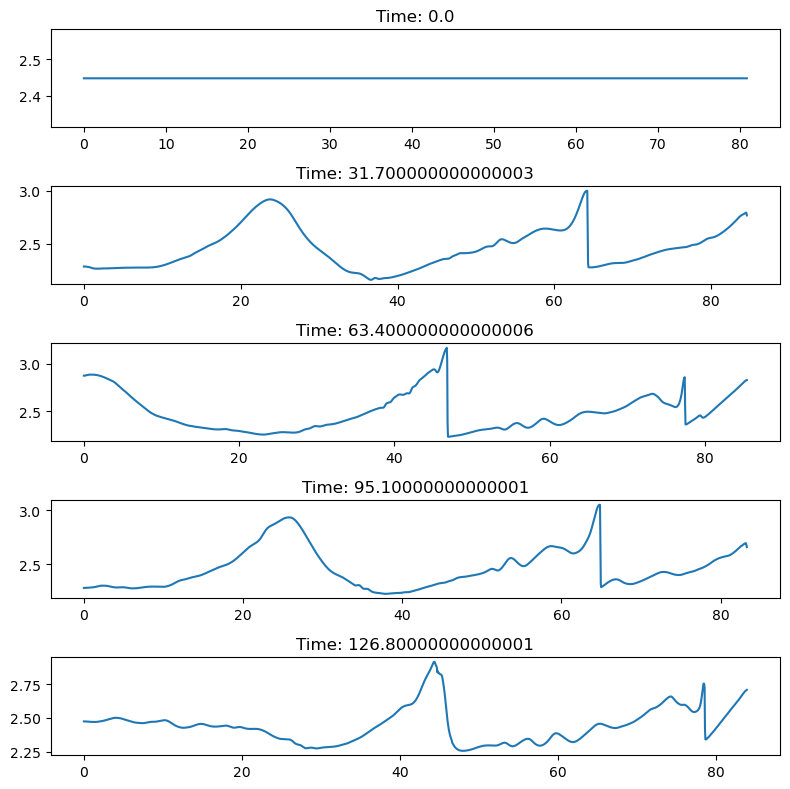

In [310]:
nrows = 5
fig, axs = plt.subplots(nrows = nrows, ncols = 1, figsize = (8,nrows * (1.6)))

# Convert the axs to an array so I can index it, helps if I add more subplots
axs = np.atleast_1d(axs)

# Calc an equal step size to fill the plots
step = math.ceil(len(model_time) / nrows)

# Get the time indices of the model_time arr to plot the data at
time_indices = [val for val in range(0, len(model_time), step)]

# Get the location of the xgrid points
model_xdir = results.var["globalx"][0, :]

# Plot each of surface vs. plots
for i, time_index in enumerate(time_indices):
    # Get the plot time
    time = model_time[time_index]

    # Set the surface elevation at the selected time
    model_zs = results.var["zs"][time_index, 0, :]

    # Plot the surface elevation w/ time
    axs[i].plot(model_xdir, model_zs, label = "Model")
    
    # Plot the measured data
    axs[i].plot()

    if True:
        axs[i].set_title(f"Time: {time}")
    if False:
        # Format the plot
        axs[i].set_xlabel("Time (s)")
        axs[i].set_ylabel("Surface elevation (m)")

plt.tight_layout()
plt.show()
# Compare it against the lab data

In [311]:
# Load the wave maker data
df_wave_maker = pd.read_csv("wave_maker.csv")
display(df_wave_maker)

# Get the time of lab measurements
lab_time = df_wave_maker["time"]

,time,location,wse
0,0.000000,0.000236,2.447915
1,0.010008,0.000449,2.448109
2,0.020006,0.000165,2.447722
3,0.030004,0.000236,2.447529
4,0.040002,0.000307,2.446885
...,...,...,...
15851,158.510003,0.000378,2.412931
15852,158.520011,0.000378,2.412223
15853,158.530009,0.000236,2.411514
15854,158.539997,0.000590,2.410805


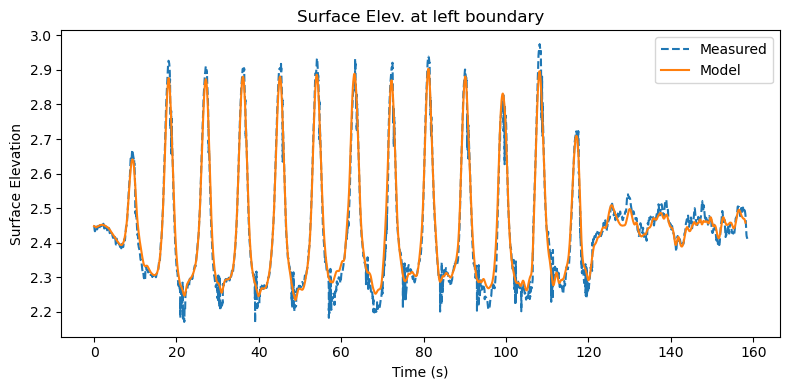

In [312]:
# Plot the data at the prescribed boundary
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (8, 4))

axs = np.atleast_1d(axs)


i = 0
axs[i].plot(lab_time, df_wave_maker["wse"], 
            linestyle = "dashed", label = "Measured")
axs[i].plot(model_time, left_boundary_zs, label = "Model")

# Format the plot
axs[i].legend()
axs[i].set_title("Surface Elev. at left boundary")
axs[i].set_xlabel("Time (s)")
axs[i].set_ylabel("Surface Elevation")

plt.tight_layout()
plt.show()

In [313]:
lab_time

0          0.000000
1          0.010008
2          0.020006
3          0.030004
4          0.040002
            ...    
15851    158.510003
15852    158.520011
15853    158.530009
15854    158.539997
15855    158.550005
Name: time, Length: 15856, dtype: float64

In [314]:
zs0 = results.var["zs"][0, 0, 0].copy()
zb  = results.var["zb"].copy()
xbeach_u = results.var["u"][:, 0, :].copy()
# get the xgrid
x_grd = results.var["globalx"][0].copy()

In [315]:
from scipy.interpolate import interp1d

# Make a function for the bathymatery
# bathy_func now takes in an x - location and outputs the corresponding z location
bathy_func = interp1d(x_grd, zb[0, 0, :])



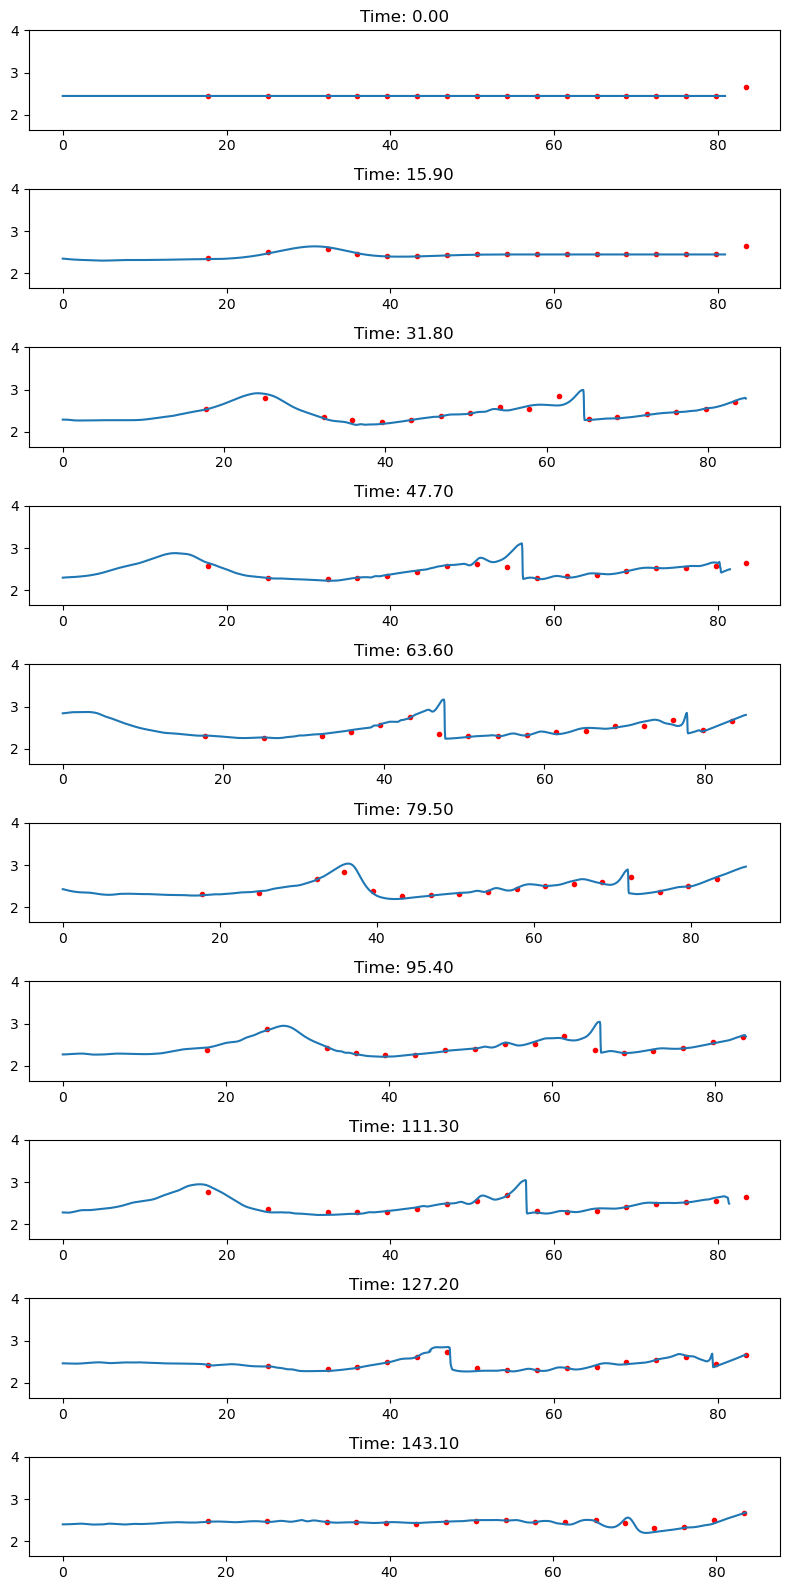

In [316]:
nrows = 10
fig, axs = plt.subplots(nrows = nrows, ncols = 1, figsize = (8,nrows * (1.6)))

# Convert the axs to an array so I can index it, helps if I add more subplots
axs = np.atleast_1d(axs)

# Calc an equal step size to fill the plots
step = math.ceil(len(model_time) / nrows)

# Get the time indices of the model_time arr to plot the data at
time_indices = [val for val in range(0, len(model_time), step)]

# Get the location of the xgrid points
model_xdir = results.var["globalx"][0, :]

# Plot each of surface vs. plots
for i, time_index in enumerate(time_indices):
    # Get the plot time
    model_t = model_time[time_index]

    # Get the closest lab time
    lab_t, lab_index = find_closest(lab_time, model_t)
    # Set the surface elevation at the selected time
    model_zs = results.var["zs"][time_index, 0, :]

    # Plot the surface elevation w/ time
    axs[i].plot(model_xdir, model_zs, label = "Model")

    # Make a copy of the wse elevation from the gauges
    lab_wse_copy = lab_wse.copy()

    # move the wave gauges up by the wse - except for the last one, it's too far too the right
    # for it to measure the d0 water level
    lab_wse_copy[lab_index, :-1] = lab_wse_copy[lab_index, :-1] + zs0

    lab_wse_copy[lab_index, -1] = lab_wse_copy[lab_index, -1] + bathy_func(lab_wg_locs[-1])

    # Plot the measured data
    axs[i].scatter(lab_wg_locs, lab_wse_copy[lab_index, :], 
                label = "lab data {:.2f}".format(lab_t),
                marker = ".", color = "red")
    
    # Plot the bathymtry
    
    # Selecting if only the waves should be plotted
    if False:
        axs[i].plot(model_xdir, zb[time_index, 0, :], label = "bathy")
    else:
        # Select only the waves
        axs[i].set_ylim(zs0-0.8, 4)

    # Setting the legend
    if False:
        axs[i].legend()
    if True:
        axs[i].set_title("Time: {:.2f}".format(model_t))

    # Setting x and y labels - get's kind of messy when there are lots of plots
    if False:
        # Format the plot
        axs[i].set_xlabel("Time (s)")
        axs[i].set_ylabel("Surface elevation (m)")

plt.tight_layout()
plt.show()
# Compare it against the lab data

In [317]:
lab_wg_locs

array([17.728, 25.037, 32.342, 35.895, 39.556, 43.215, 46.876, 50.53 ,
       54.192, 57.85 , 61.509, 65.205, 68.759, 72.405, 76.068, 79.738,
       83.385])

### Calculating the RMSE between the xbeach surface elevation and the lab surface elevation

1431
143.1
[0.0 0.0 0.0 ... 0.0 0.0 0.0]


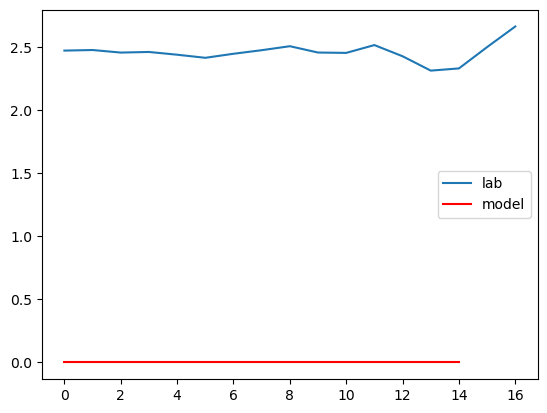

error 2.4441978492390013


In [320]:
# Don't include the last one for the time being since it has to account for run-up,
# which I'm not really accounting for at this time
selected_wg_locs = lab_wg_locs[:-2]

# Init array to store the RMSE at each time
wse_RMSE = np.zeros(len(model_time))

# Loop over the model times
for i, time in enumerate(model_time):
    # print("Time", time)
    model_zs = results.var["zs"][i, 0, :].copy()

    # Set all the masked values to zero
    model_zs[model_zs.mask == True] =0.0

    # unmaked_model_xdir = model_xdir[model_zs.mask == False]
    # Make a function that calculates the xbeach surface elevation given the location
    model_zs_func = interp1d(model_xdir, np.ma.getdata(model_zs))

    # Interpolate that function onto the location of the sensors
    interp_model_zs = model_zs_func(selected_wg_locs)
    # _, interp_model_zs = find
    # Find the closest time in the lab dataset
    # Lab data set is collected at a much higher temporal resolution
    _, lab_index = find_closest(lab_time, time)

    # Make a copy of the wse elevation from the gauges
    lab_wse_copy = lab_wse[lab_index, :].copy()

    # print("len lab", len(lab_wse_copy))
    # print("len interp model", len(interp_model_zs))
    # move the wave gauges up by the wse - except for the last one, it's too far too the right
    # for it to measure the d0 water level
    lab_wse_copy[:-1] = lab_wse_copy[:-1] + zs0

    lab_wse_copy[-1] = lab_wse_copy[-1] + bathy_func(lab_wg_locs[-1])

    # Calc the RMSE for that time step
    error = calc_RMSE(lab_wse_copy[:-2], interp_model_zs)
    # print(error)

    wse_RMSE[i] = error

    if error > 1.0:
        print(i)
        print(time)
        plt.plot(lab_wse_copy, label = "lab")
        plt.plot(interp_model_zs, label = "model", color ="red")
        # plt.plot(model_xdir, model_zs, label = "full data")
        print(model_zs)
        plt.legend()
        plt.show()
        print("error", error)
        # Store the calculate RMSE


In [321]:
results.var["zs"][1431, 0, :]

masked_array(data=[0.0, 0.0, 0.0, ..., --, --, --],
             mask=[False, False, False, ...,  True,  True,  True],
       fill_value=-3.4028234663852886e+38)

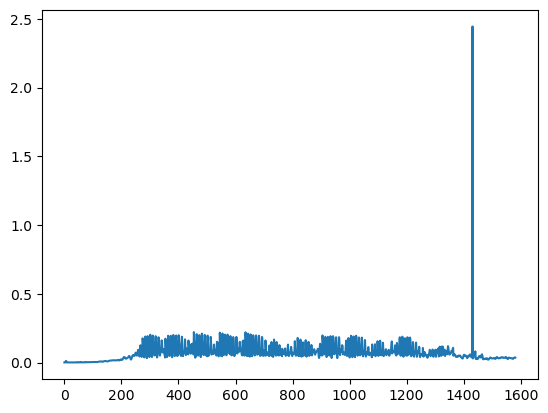

In [322]:
plt.plot(wse_RMSE)

In [323]:
wse_RMSE.mean()*100

7.204410907070204

In [324]:
# Reinterpolate the xbeach data onto the locations of the sensors

In [325]:
lab_wse.shape

(15856, 17)

In [326]:
results.var["zs"].shape

(1582, 1, 1745)

### Process the velocity data

In [327]:
results.load_modeloutput("u")
u = results.var["u"]

Variable already loaded


In [328]:
df = pd.read_csv("boun_U.bcf", sep = "\\s+", skiprows=3, header=None, names=["t", "zs", "u"])

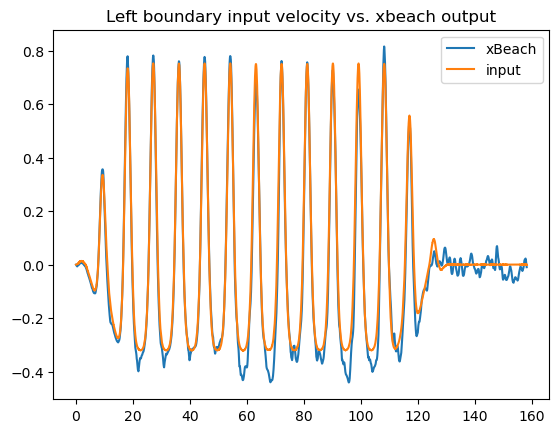

In [329]:
plt.plot(model_time, u[:, 0, 0], label = "xBeach")
plt.plot(df["t"], df["u"], label = "input")
plt.title("Left boundary input velocity vs. xbeach output")
plt.legend()
plt.show()

In [330]:
print(Run_data.wave_gauges[-1])

Wave Gauge Type: ultrasonic
Gauge Id: 17
Location: (83.385, -1.37)


In [331]:
# Let's plot the regular velocity
for adv in Run_data.ADVs:
    print(adv)
    print()

Sensor Name: ADV1 
Sensor id: 1
Flume Height, z (m): 1.567

Sensor Name: ADV2 
Sensor id: 2
Flume Height, z (m): 1.761

Sensor Name: ADV3 
Sensor id: 3
Flume Height, z (m): 1.962

Sensor Name: ADV4 
Sensor id: 4
Flume Height, z (m): 2.162

Sensor Name: ADV5 
Sensor id: 5
Flume Height, z (m): 2.359

Sensor Name: ADV6 
Sensor id: 6
Flume Height, z (m): 2.5599999999999996



In [332]:
print(Run_data.ADVs[0])

Sensor Name: ADV1 
Sensor id: 1
Flume Height, z (m): 1.567


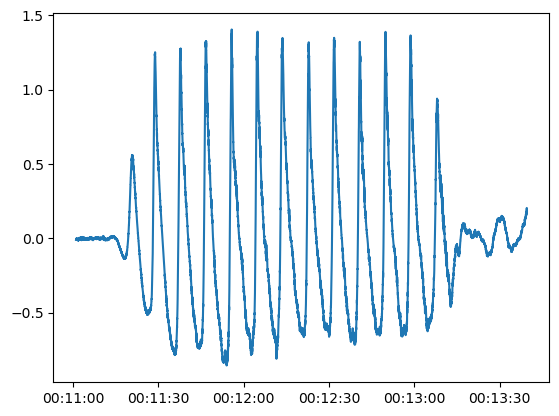

In [333]:
Run_data.ADVs[0].vel["u"]

# Construct a plot to hold the adv data
plt.plot(Run_data.date_time, Run_data.ADVs[0].vel["u"])

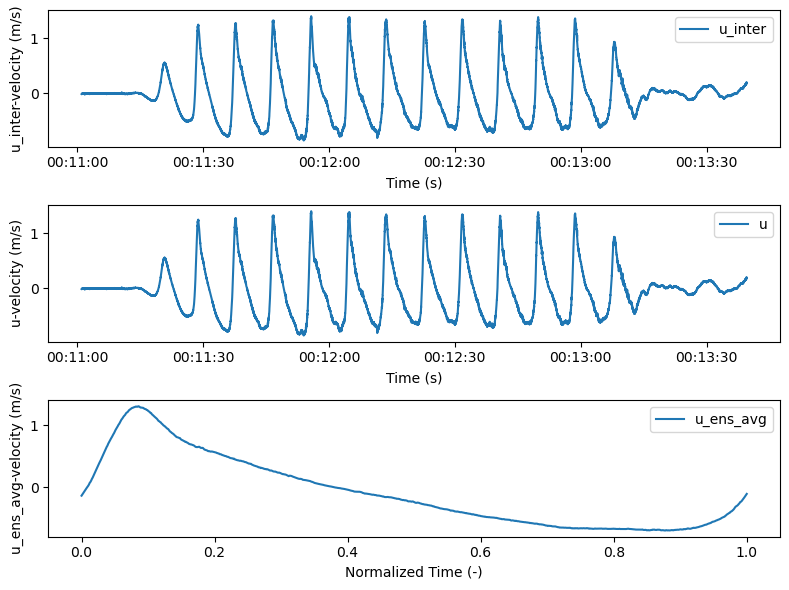

In [334]:
Run_data.ADVs[0].quick_plot(keys = ["u_inter", "u", "u_ens_avg"], legend = True, figsize = (8, 6))

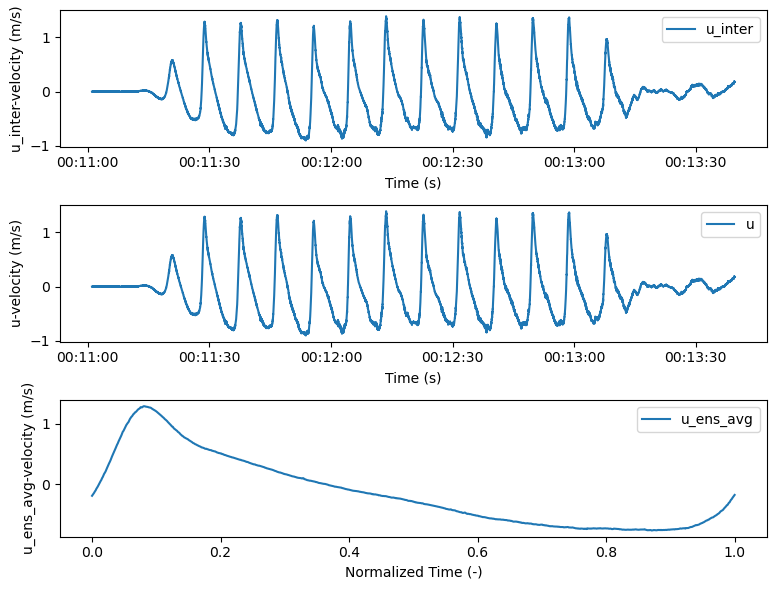

In [335]:
Run_data.ADVs[1].quick_plot(keys = ["u_inter", "u", "u_ens_avg"], legend = True, figsize = (8, 6))

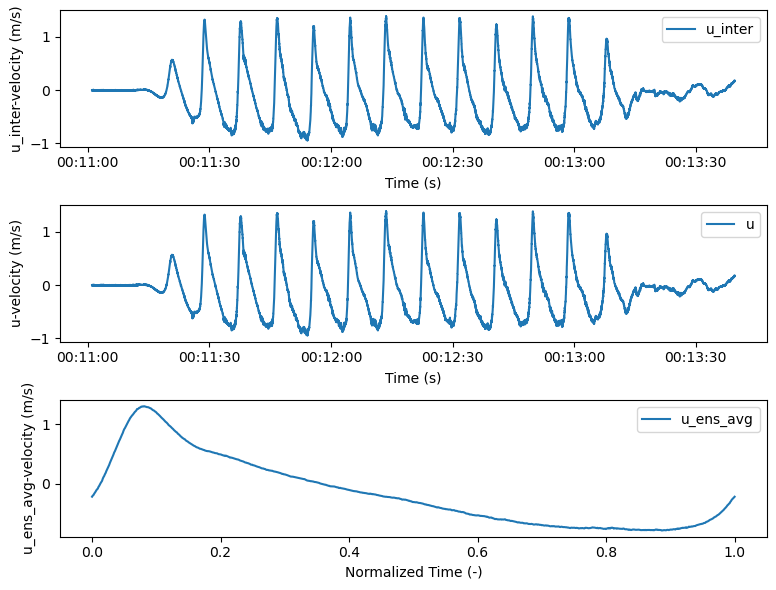

In [336]:
Run_data.ADVs[2].quick_plot(keys = ["u_inter", "u", "u_ens_avg"], legend = True, figsize = (8, 6))

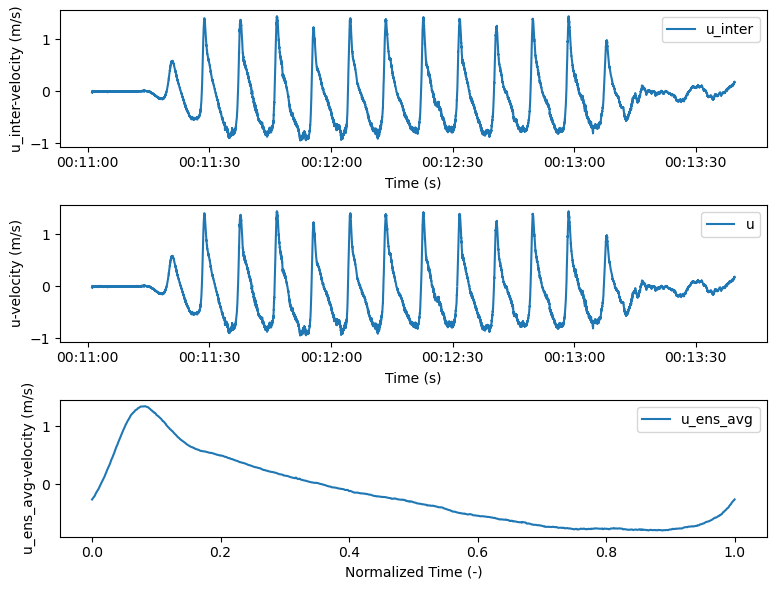

In [337]:
Run_data.ADVs[3].quick_plot(keys = ["u_inter", "u", "u_ens_avg"], legend = True, figsize = (8, 6))

In [338]:
print(Run_data.ADVs[4])

Sensor Name: ADV5 
Sensor id: 5
Flume Height, z (m): 2.359


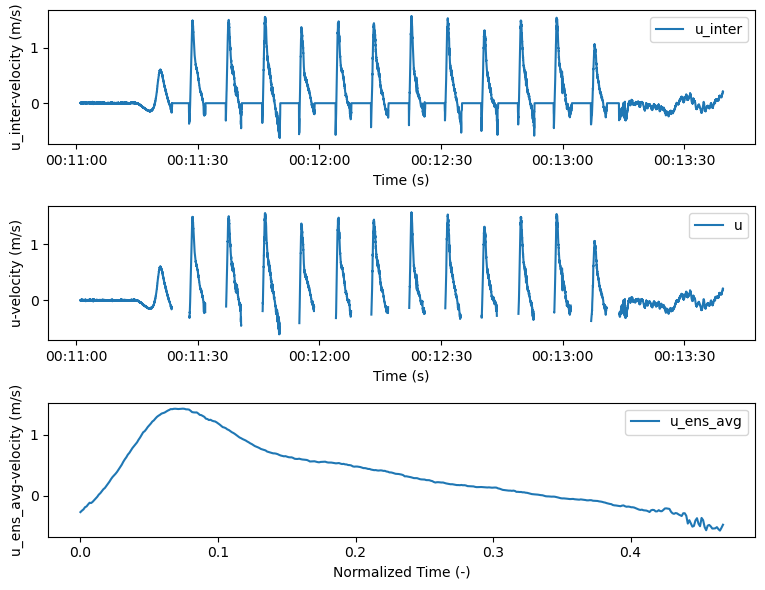

In [339]:
Run_data.ADVs[4].quick_plot(keys = ["u_inter", "u", "u_ens_avg"], legend = True, figsize = (8, 6))

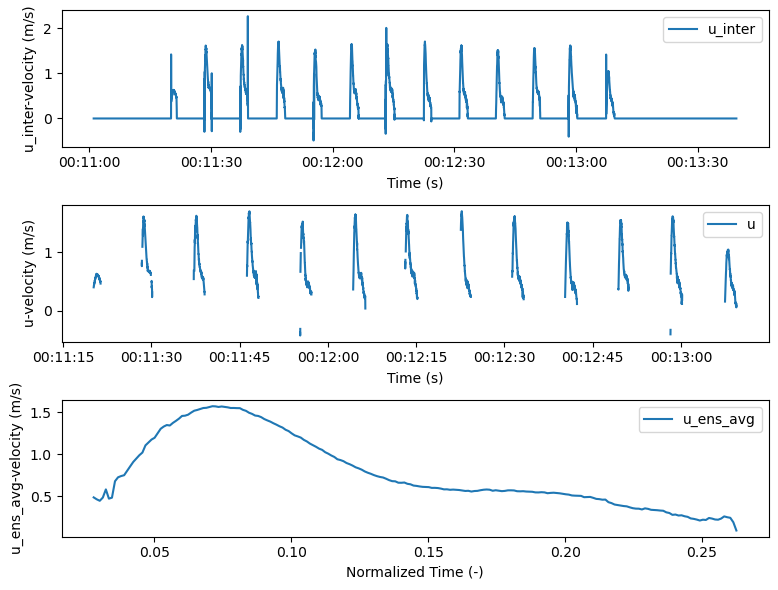

In [340]:
Run_data.ADVs[5].quick_plot(keys = ["u_inter", "u", "u_ens_avg"], legend = True, figsize = (8, 6))

In [341]:
Run_data.ADVs[5].vel["u"]

array([nan, nan, nan, ..., nan, nan, nan])

In [342]:
# Depth average the velocity
Run_data.ADVs[0].vel["u"]

# Init variable to track the sum of the cleaned velocities
sum_u = 0.0

# Make an array to track how many times each indice is summed with a non-nan value
num_sensors = np.zeros(len(Run_data.ADVs[0].vel["u"]))
# Loop over the advs
for i, adv in enumerate(Run_data.ADVs[:6]):
    # Sum the cleaned velocity
    u = adv.vel["u"]
    
    # Make an array where the values are zero if the value is nan and 1 if it's not nan
    int_mask = np.where(np.isnan(u), 0, 1)

    sum_u += np.nan_to_num(u)
    # Make this an array that keeps track of how many times each element has been summed
    # Some of the values are NaN in the arrays so we need to be able to keep track of each element 
    num_sensors += int_mask

lab_u_avg = sum_u/num_sensors

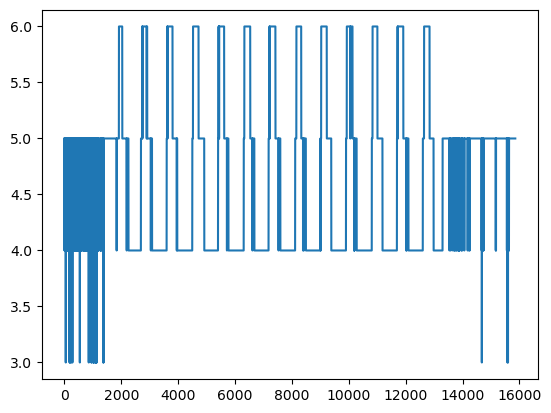

In [343]:
plt.plot(num_sensors)

In [344]:
print(num_sensors)

[5. 5. 5. ... 5. 5. 5.]


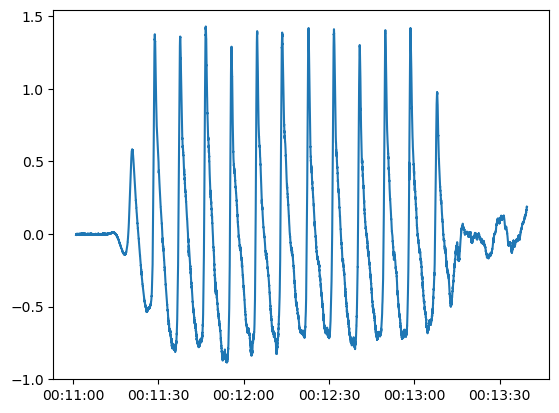

In [345]:
plt.plot(Run_data.date_time, lab_u_avg)

### Information about the ADV
The location of the ADV array was (45 m, 0.57 m) where the flume centerline (along the x-direction) is y = 0. This information came from page 6 of Mieras et al. Large-scale experimental observations of sheet flo.pdf <br>

**Note**: The ADVs are off center. Just pointing that out so I don't forget. I'm not sure if the measurement is the location of the base of the adv or the actual measuring probe.

In [346]:
# Set the coordinate for the advs
lab_adv_xy_coord = [45, 0.57]

# Find the closest location in the grid to the location of the Advs
closest_loc, xdir_index = find_closest(model_xdir, lab_adv_xy_coord[0])

print(f"The closest location to 45 [m] for this grid is at: {closest_loc} [m]")

The closest location to 45 [m] for this grid is at: 44.998 [m]


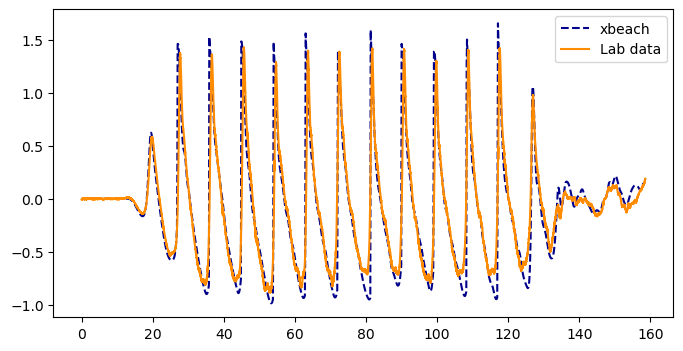

In [347]:
# Plot the xBeach velocity at the closest location

fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (8, 4))

axs = np.atleast_1d(axs)

axs[0].plot(model_time, xbeach_u[:, xdir_index], label = "xbeach",
            color = "darkblue", linestyle = "dashed")
axs[0].plot(lab_time, lab_u_avg, label = "Lab data", 
            color = "darkorange")
plt.legend()
plt.show() 

In [348]:
len(model_time)

1582

### Calc the RMSE

1) Resample the lab data onto the xbeach time series
2) Calc the RMSE
$$RMSE = \sqrt{\sum_{i=1}^{n} \frac{ (\hat{y}_{i} - y_{i})^{2} }{n}}$$

where <br>
$\hat{y}_{i}$ are the predicted values <br>
$y_{i}$ are the observed values <br>
$n$ is the number of observations <br>

In [349]:
# Resample the lab data onto the model time.
# There's a lot more lab data than model data for the current time step configuration
lab_u_func = interp1d(lab_time, lab_u_avg)

# Interpolate the model 
resamp_lab_u_avg = lab_u_func(model_time)

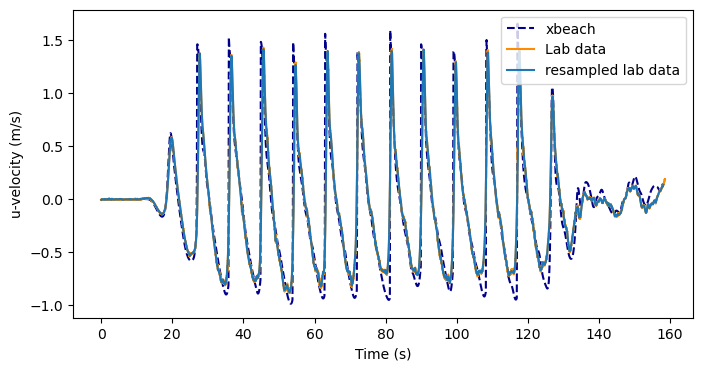

In [350]:
# Plot the xBeach velocity at the closest location

fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (8, 4))

axs = np.atleast_1d(axs)

axs[0].plot(model_time, xbeach_u[:, xdir_index], label = "xbeach",
            color = "darkblue", linestyle = "dashed")

axs[0].plot(lab_time, lab_u_avg, label = "Lab data", 
            color = "darkorange")

axs[0].plot(model_time, resamp_lab_u_avg, label = "resampled lab data")

axs[0].set_ylabel("u-velocity (m/s)")
axs[0].set_xlabel("Time (s)")
plt.legend()
plt.show() 

In [351]:
# Calc the rmse between the reinterpolated velocity
u_avg_RMSE = calc_RMSE(resamp_lab_u_avg, xbeach_u[:, xdir_index])

print(f"u-avg RMSE: {u_avg_RMSE * 100:.2f}%")

u-avg RMSE: 23.13%
